## Investing deforestation in the DRC using GFC data for selected Protected Areas

### Section 1: Data prep

#### Install these R packages first, and load them into the R session. Source R script with support functions.

In [1]:
packages <- c("raster", "rgdal", "rgeos", "geosphere","RColorBrewer","gdalUtils","ff","parallel", "snow","leaflet")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})

source('/projects/shared-buckets/leitoldv/biomass_support2.R')

Loading required package: raster

Loading required package: sp

Loading required package: rgdal

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.3.2, released 2021/09/01
Path to GDAL shared files: /opt/conda/envs/r-with-gdal/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.0.1, March 5th, 2021, [PJ_VERSION: 801]
Path to PROJ shared files: /opt/conda/envs/r-with-gdal/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Loading required package: rgeos

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rgeos’”
also installing the dependencies ‘foreign’, ‘maptools’, ‘maps’


Updating HTML index of packages in '.Library'

Making 'packages.

#### Read in world countries shapefile & set the path to the GFC data folder

In [2]:
#Country polygons
world <- readOGR("/projects/shared-buckets/leitoldv/NaturalEarth/ne_10m_admin_0_countries.shp")

#Hansen forest cover, resampled to CCI Biomass and JPL resolutions
gfc_folder <- "/projects/shared-buckets/leitoldv/gfc_data"

OGR data source with driver: ESRI Shapefile 
Source: "/projects/shared-buckets/leitoldv/NaturalEarth/ne_10m_admin_0_countries.shp", layer: "ne_10m_admin_0_countries"
with 255 features
It has 94 fields
Integer64 fields read as strings:  POP_EST NE_ID 


#### Generate 10x10 degree WGS84 grid that the GFC product is tiled on

In [3]:
gt <- GridTopology(c(-180 + 5, -60 + 5), c(10, 10), c(36,14))
grd <- SpatialGrid(gt, proj4string="+init=epsg:4326")
spix <- as(grd, "SpatialPixels")
spol <- as(spix, "SpatialPolygons")
gfc_tiles <- spol

Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


#### Select a country in Africa to plot with corresponding data tiles

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

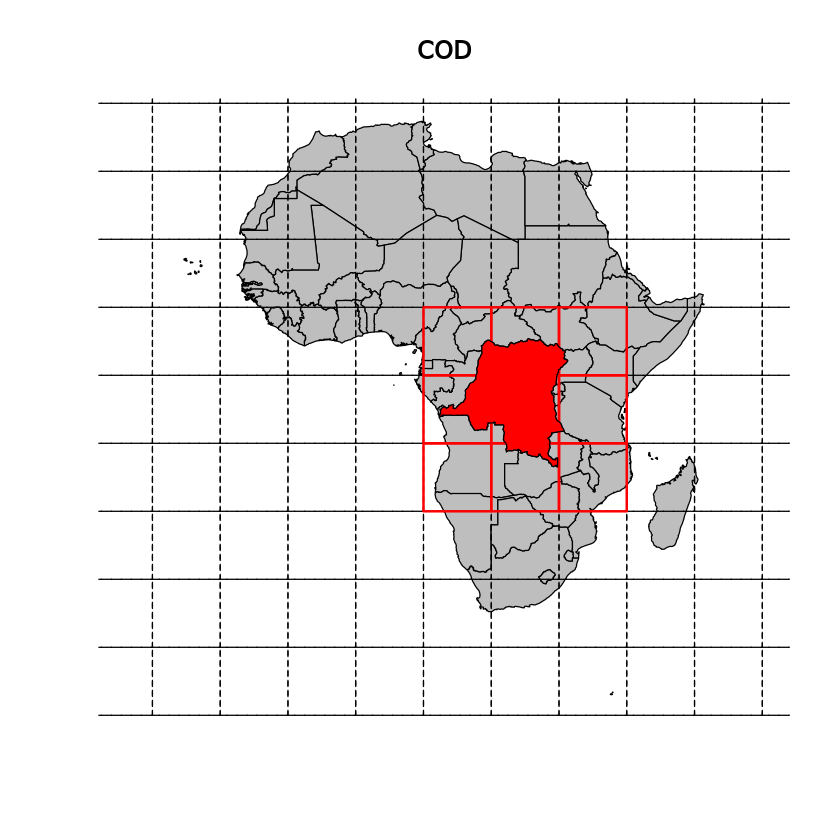

In [4]:
Cont <- world[world$CONTINENT=="Africa",]
iso3 <- c("COD") # Democratic Republic of the Congo (COD)
aoi <- world[world$ADM0_A3 %in% iso3,]

crs(aoi)
crs(gfc_tiles)

if (!identical(crs(aoi), crs(gfc_tiles))){aoi <- spTransform(aoi, crs(gfc_tiles))}
intersecting <- as.logical(gIntersects(gfc_tiles, gConvexHull(aoi), byid=TRUE) & !gTouches(gfc_tiles, gConvexHull(aoi), byid=TRUE))
  if (sum(intersecting) == 0) {stop('no intersecting CCI Biomass tiles found')
  } else {
    tiles <- gfc_tiles[intersecting,]
  }

plot(Cont, col="gray", main=iso3)
plot(gfc_tiles, lty=2, add=T)
plot(tiles, lwd=2, border="red", add=T)
plot(aoi, col="red", add=T)

# Transform aoi to match tiles CRS so it can be used later for cropping
aoi <- spTransform(aoi, crs(tiles))

#### (Done) Read in the Hansen GFC lossmask tiles for this AOI, mosaicing multiple tiles as necessary

In [7]:
# gfc <- readGFC(data_folder=gfc_folder, aoi=aoi, image="lossmask")

#### Read in the Protected Areas GeoJSON and set the coordinate system to match the AOI

In [5]:
PA <- readOGR("../shared-buckets/tkerr1/data/DRC_protected_areas/Protected_Areas_DRC.geojson")
PA <- spTransform(PA, crs("EPSG:4326"))

OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/tkerr1/data/DRC_protected_areas/Protected_Areas_DRC.geojson", layer: "Protected_Areas_DRC"
with 1 features
It has 1 fields


#### Plot the Protected Areas GeoJSON

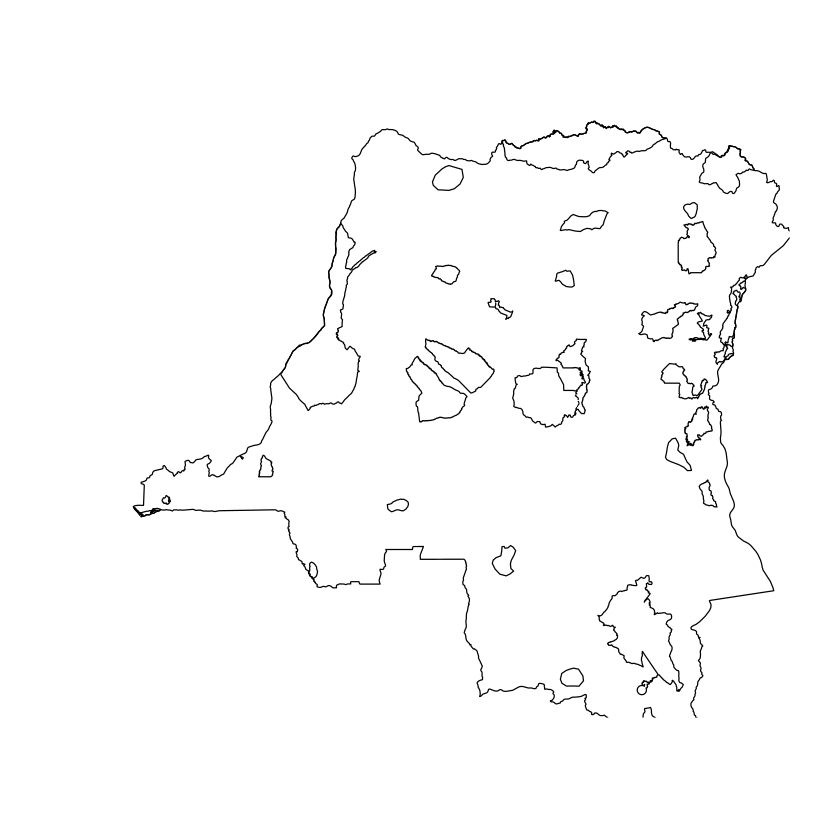

In [9]:
plot(PA); plot(aoi, add=T)

#### (Done) Crop the GFC tiles to the AOI

In [10]:
# gfc_masked <- mask(gfc, aoi, updatevalue=NA)
# gfc_masked <- crop(gfc_masked, aoi)

#### Checkpoint: Write out and read in cropped GFC data

In [11]:
# save_folder = "/projects/my-public-bucket/data/gfc_masked"

# filename<-file.path(save_folder, paste('gfc_masked', aoi@data$SOVEREIGNT, sep="_"))
# writeRaster(gfc_masked, filename=filename, format="GTiff", overwrite=TRUE)

In [5]:
threshold_folder = "/projects/shared-buckets/tkerr1/data/gfc_masked"

filename <- file.path(threshold_folder, paste0('gfc_masked_', aoi@data$SOVEREIGNT, ".tif"))
gfc_masked <- raster(x=filename)

names(gfc_masked) <- c('lossmask')

### Section 2: Crop the GFC tiles to Protected Areas

#### Splitting up the protected areas into a list

In [6]:
maskPA <- function(PA, product){
    product_maskedPA <- crop(product, PA)
    product_maskedPA <- mask(product_maskedPA, PA, updatevalue=NA)

    return(product_maskedPA)
}

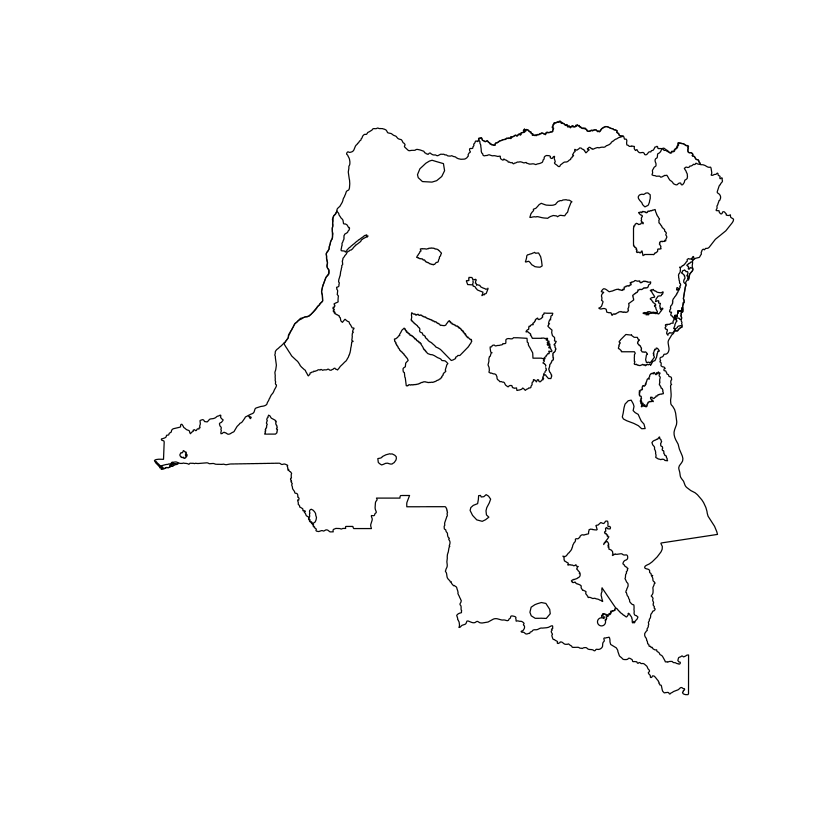

In [29]:
# Change PA from single multipolygon to list of polygons

IDs <- seq(1:length(PA@polygons[[1]]@Polygons))
PA_list <- mapply(function(x,y){SpatialPolygons(list(Polygons(list(x),y)))}, PA@polygons[[1]]@Polygons, IDs)

plot(aoi); invisible(lapply(PA_list, plot, add=T))

In [30]:
gfc_maskedPA <- lapply(PA_list, maskPA, product=gfc_masked)

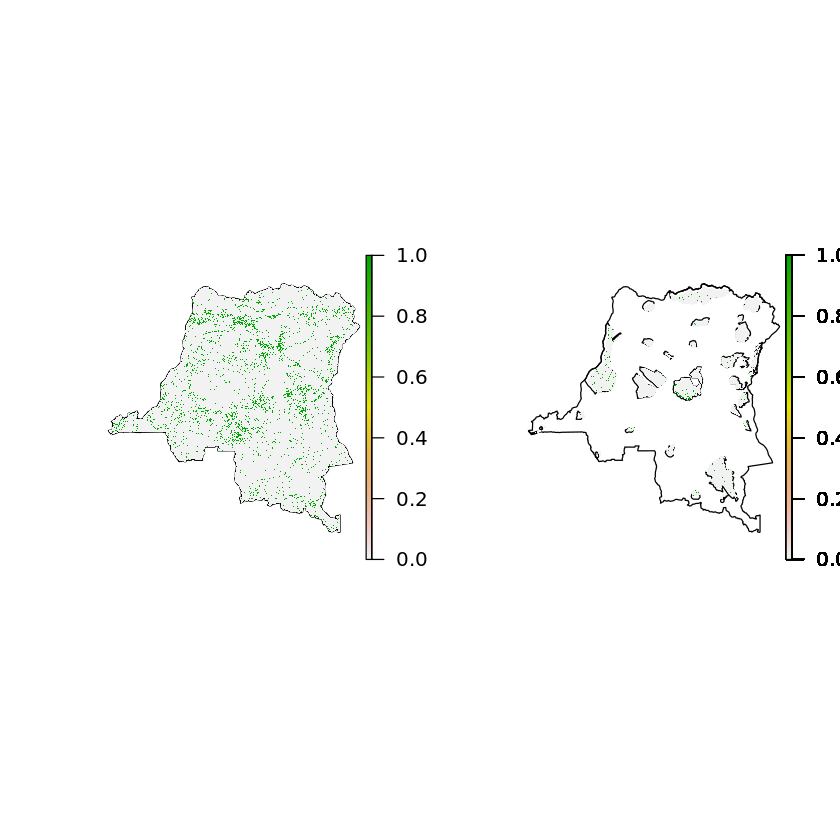

In [31]:
par(mfrow=c(1,2))

plot(aoi)
plot(gfc_masked, add=T)

plot(aoi)
plot(PA, add=T)
invisible(lapply(gfc_maskedPA, plot, add=T, zlim=c(0,1)))

#### (Done) Convert the masked PA list to a raster

In [32]:
# gfc_maskedPA_merged <- do.call(merge, gfc_maskedPA)

#### Checkpoint: Write out and read in cropped GFC data to PA

In [ ]:
# save_folder = "/projects/my-public-bucket/data/gfc_maskedPA"

# filename<-file.path(save_folder, paste('gfc_maskedPA', aoi@data$SOVEREIGNT, sep="_"))
# writeRaster(gfc_maskedPA_merged, filename=filename, format="GTiff", overwrite=TRUE)

In [7]:
threshold_folder = "/projects/shared-buckets/tkerr1/data/gfc_maskedPA"

filename <- file.path(threshold_folder, paste0('gfc_maskedPA_', aoi@data$SOVEREIGNT, ".tif"))
gfc_maskedPA <- raster(x=filename)

names(gfc_maskedPA) <- c('lossmask')

### Section 3: Misc. testing of various protected areas to see their GFC loss

#### Plot the PAs with their polygon IDs

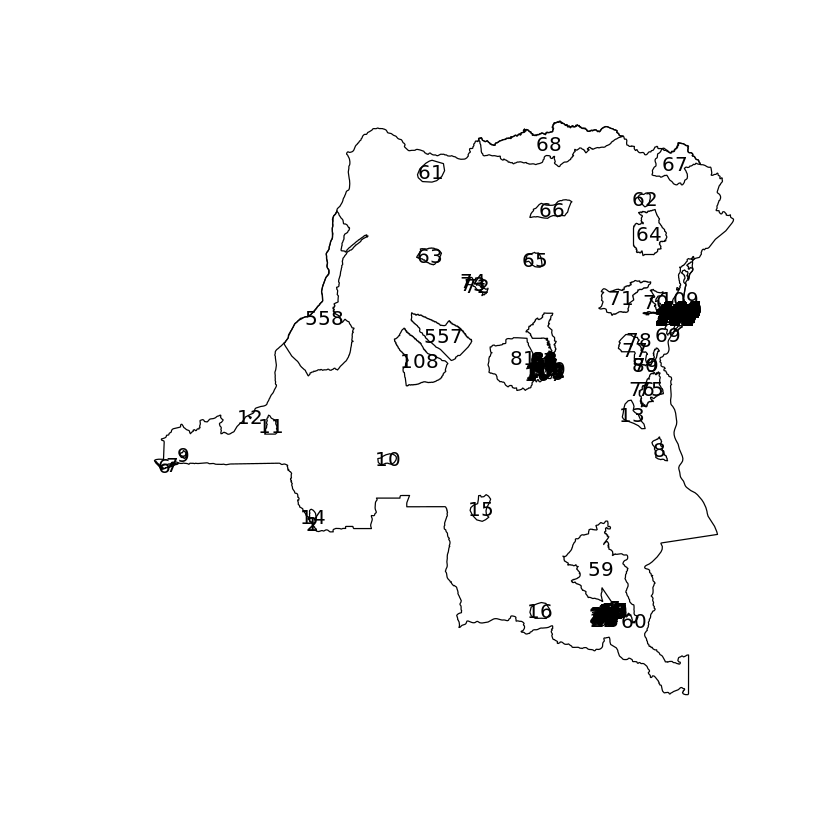

In [15]:
plot(aoi)
plot(PA, add=T)

PA_reshape <- do.call(bind, PA_list) 
PA_reshape <- SpatialPolygonsDataFrame(PA_reshape, data.frame(ID=IDs))
cent <- gCentroid(PA_reshape, byid=T)

text(cent@coords, label = PA_reshape@data$ID)

#### Selecting one PA to view with the GFC lossmask data

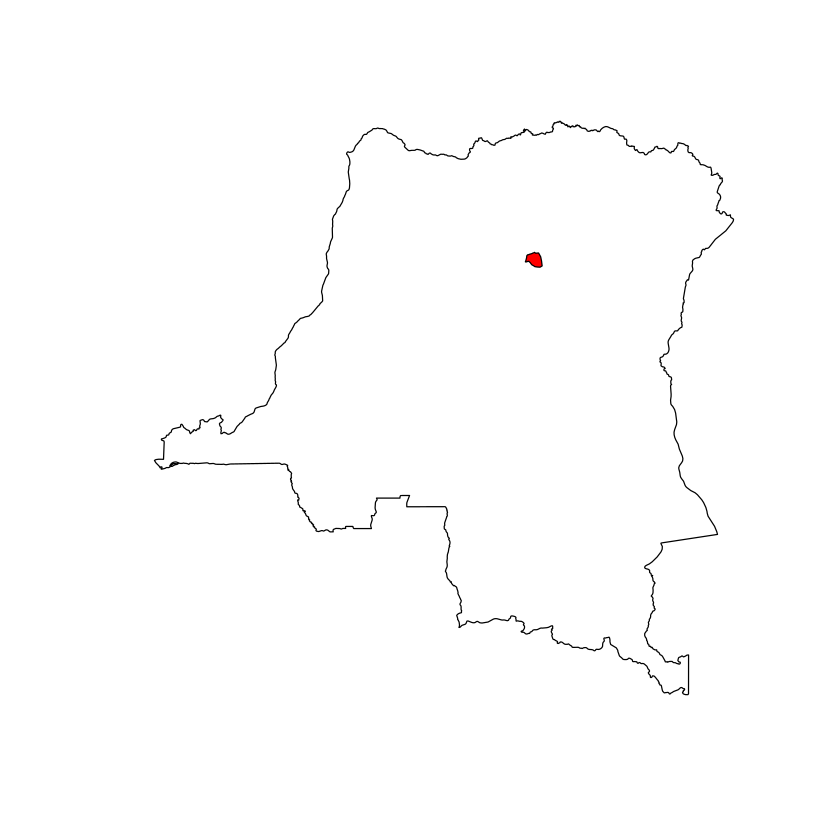

In [25]:
PA_sub <-  SpatialPolygons(list(Polygons(PA@polygons[[1]]@Polygons[65], 1)))
proj4string(PA_sub) <- crs(PA)
plot(aoi)
plot(PA_sub,add=T,col='red')

In [26]:
gfc_maskedPA_sub <- maskPA(PA_sub, gfc_masked)

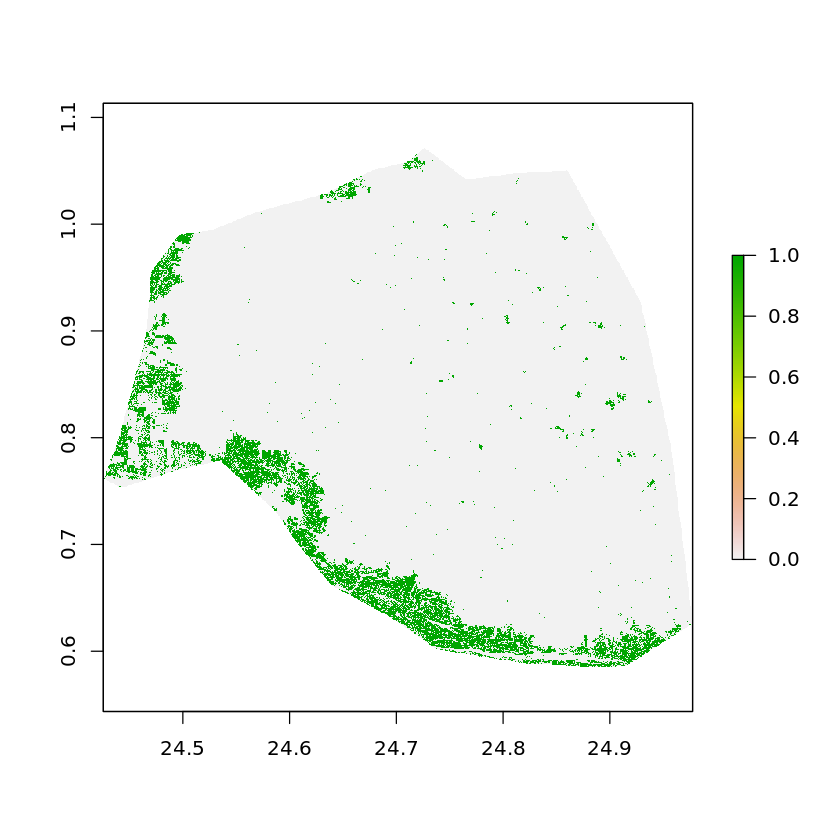

In [27]:
plot(gfc_maskedPA_sub)

### Section 4: Viewing the GFC lossmask data for the selected PAs

#### Reading in and plotting the gfc in the selected PAs

In [8]:
# This PA was selected using GEDI data, which ranked it at the bottom of the list for "effectiveness"
PA_1 <- readOGR("../shared-buckets/tkerr1/data/PA_1/PA_1_20331.geojson")

OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/tkerr1/data/PA_1/PA_1_20331.geojson", layer: "PA_1_20331"
with 1 features
It has 31 fields


In [9]:
# This PA was selected after seeing an interesting GFC pattern. See the PA_sub plot above
PA_2 <- readOGR("../shared-buckets/tkerr1/data/PA_2/PA_2_555512072.geojson")

OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/tkerr1/data/PA_2/PA_2_555512072.geojson", layer: "PA_2_555512072"
with 1 features
It has 31 fields


In [10]:
PA_1_masked <- maskPA(PA_1, gfc_masked)

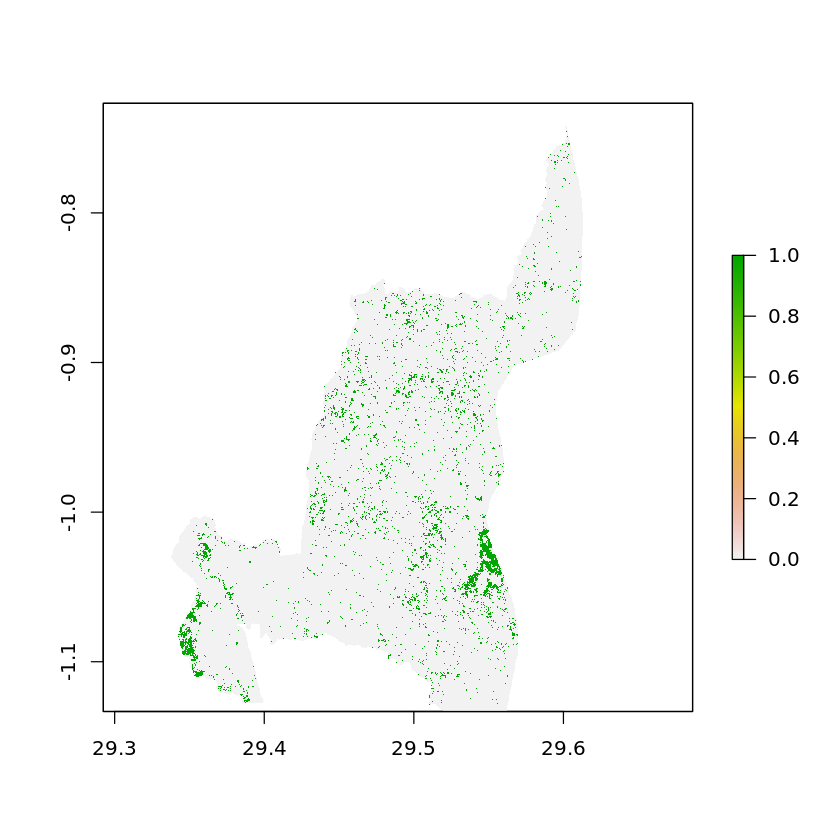

In [11]:
plot(PA_1_masked)

In [12]:
PA_2_masked <- maskPA(PA_2, gfc_masked)

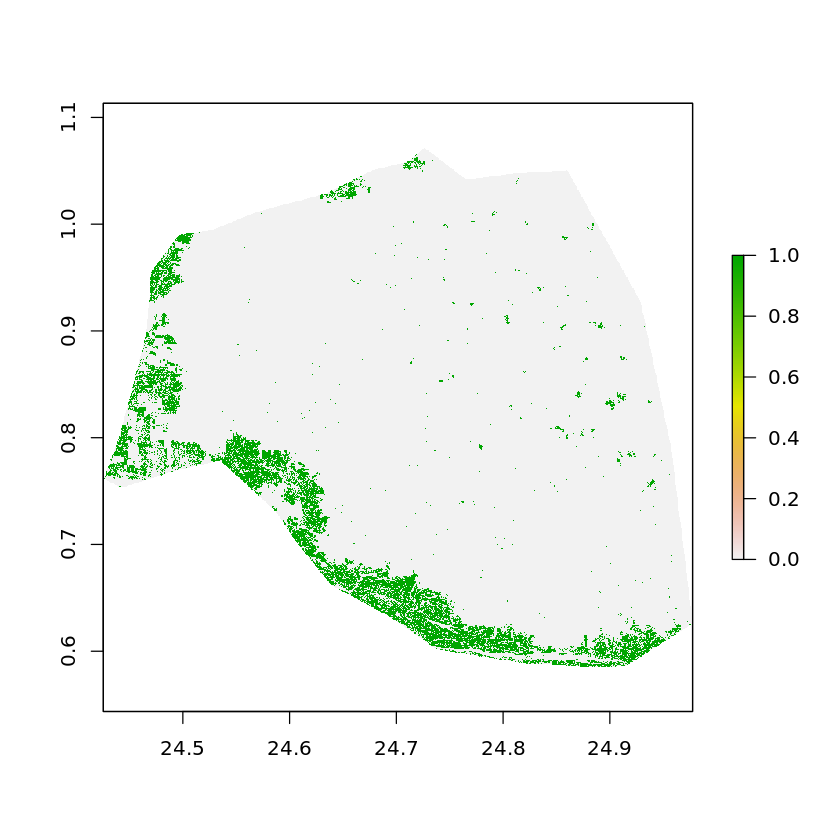

In [13]:
plot(PA_2_masked)

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum World Geodetic System 1984 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded ellps WGS 84 in Proj4 definition: +proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum World Geodetic System 1984 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded ellps WGS 8

HTML widgets cannot be represented in plain text (need html)
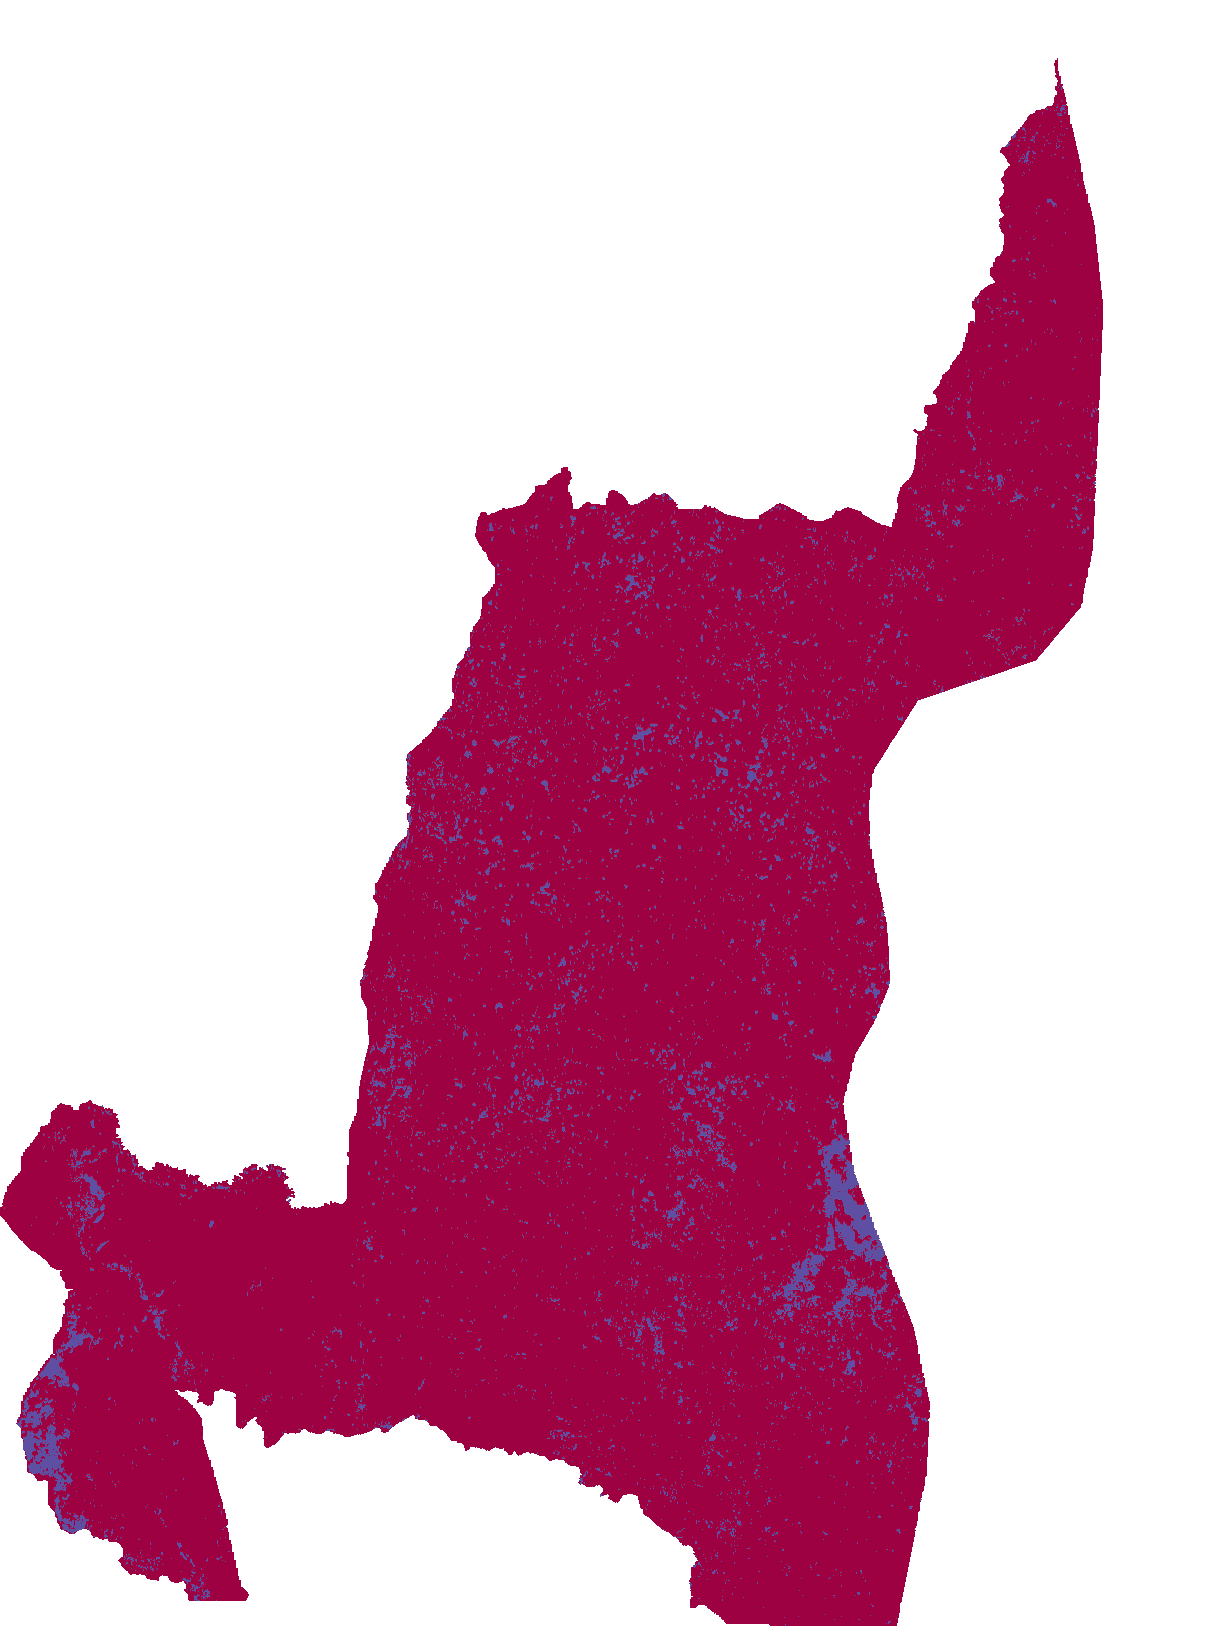
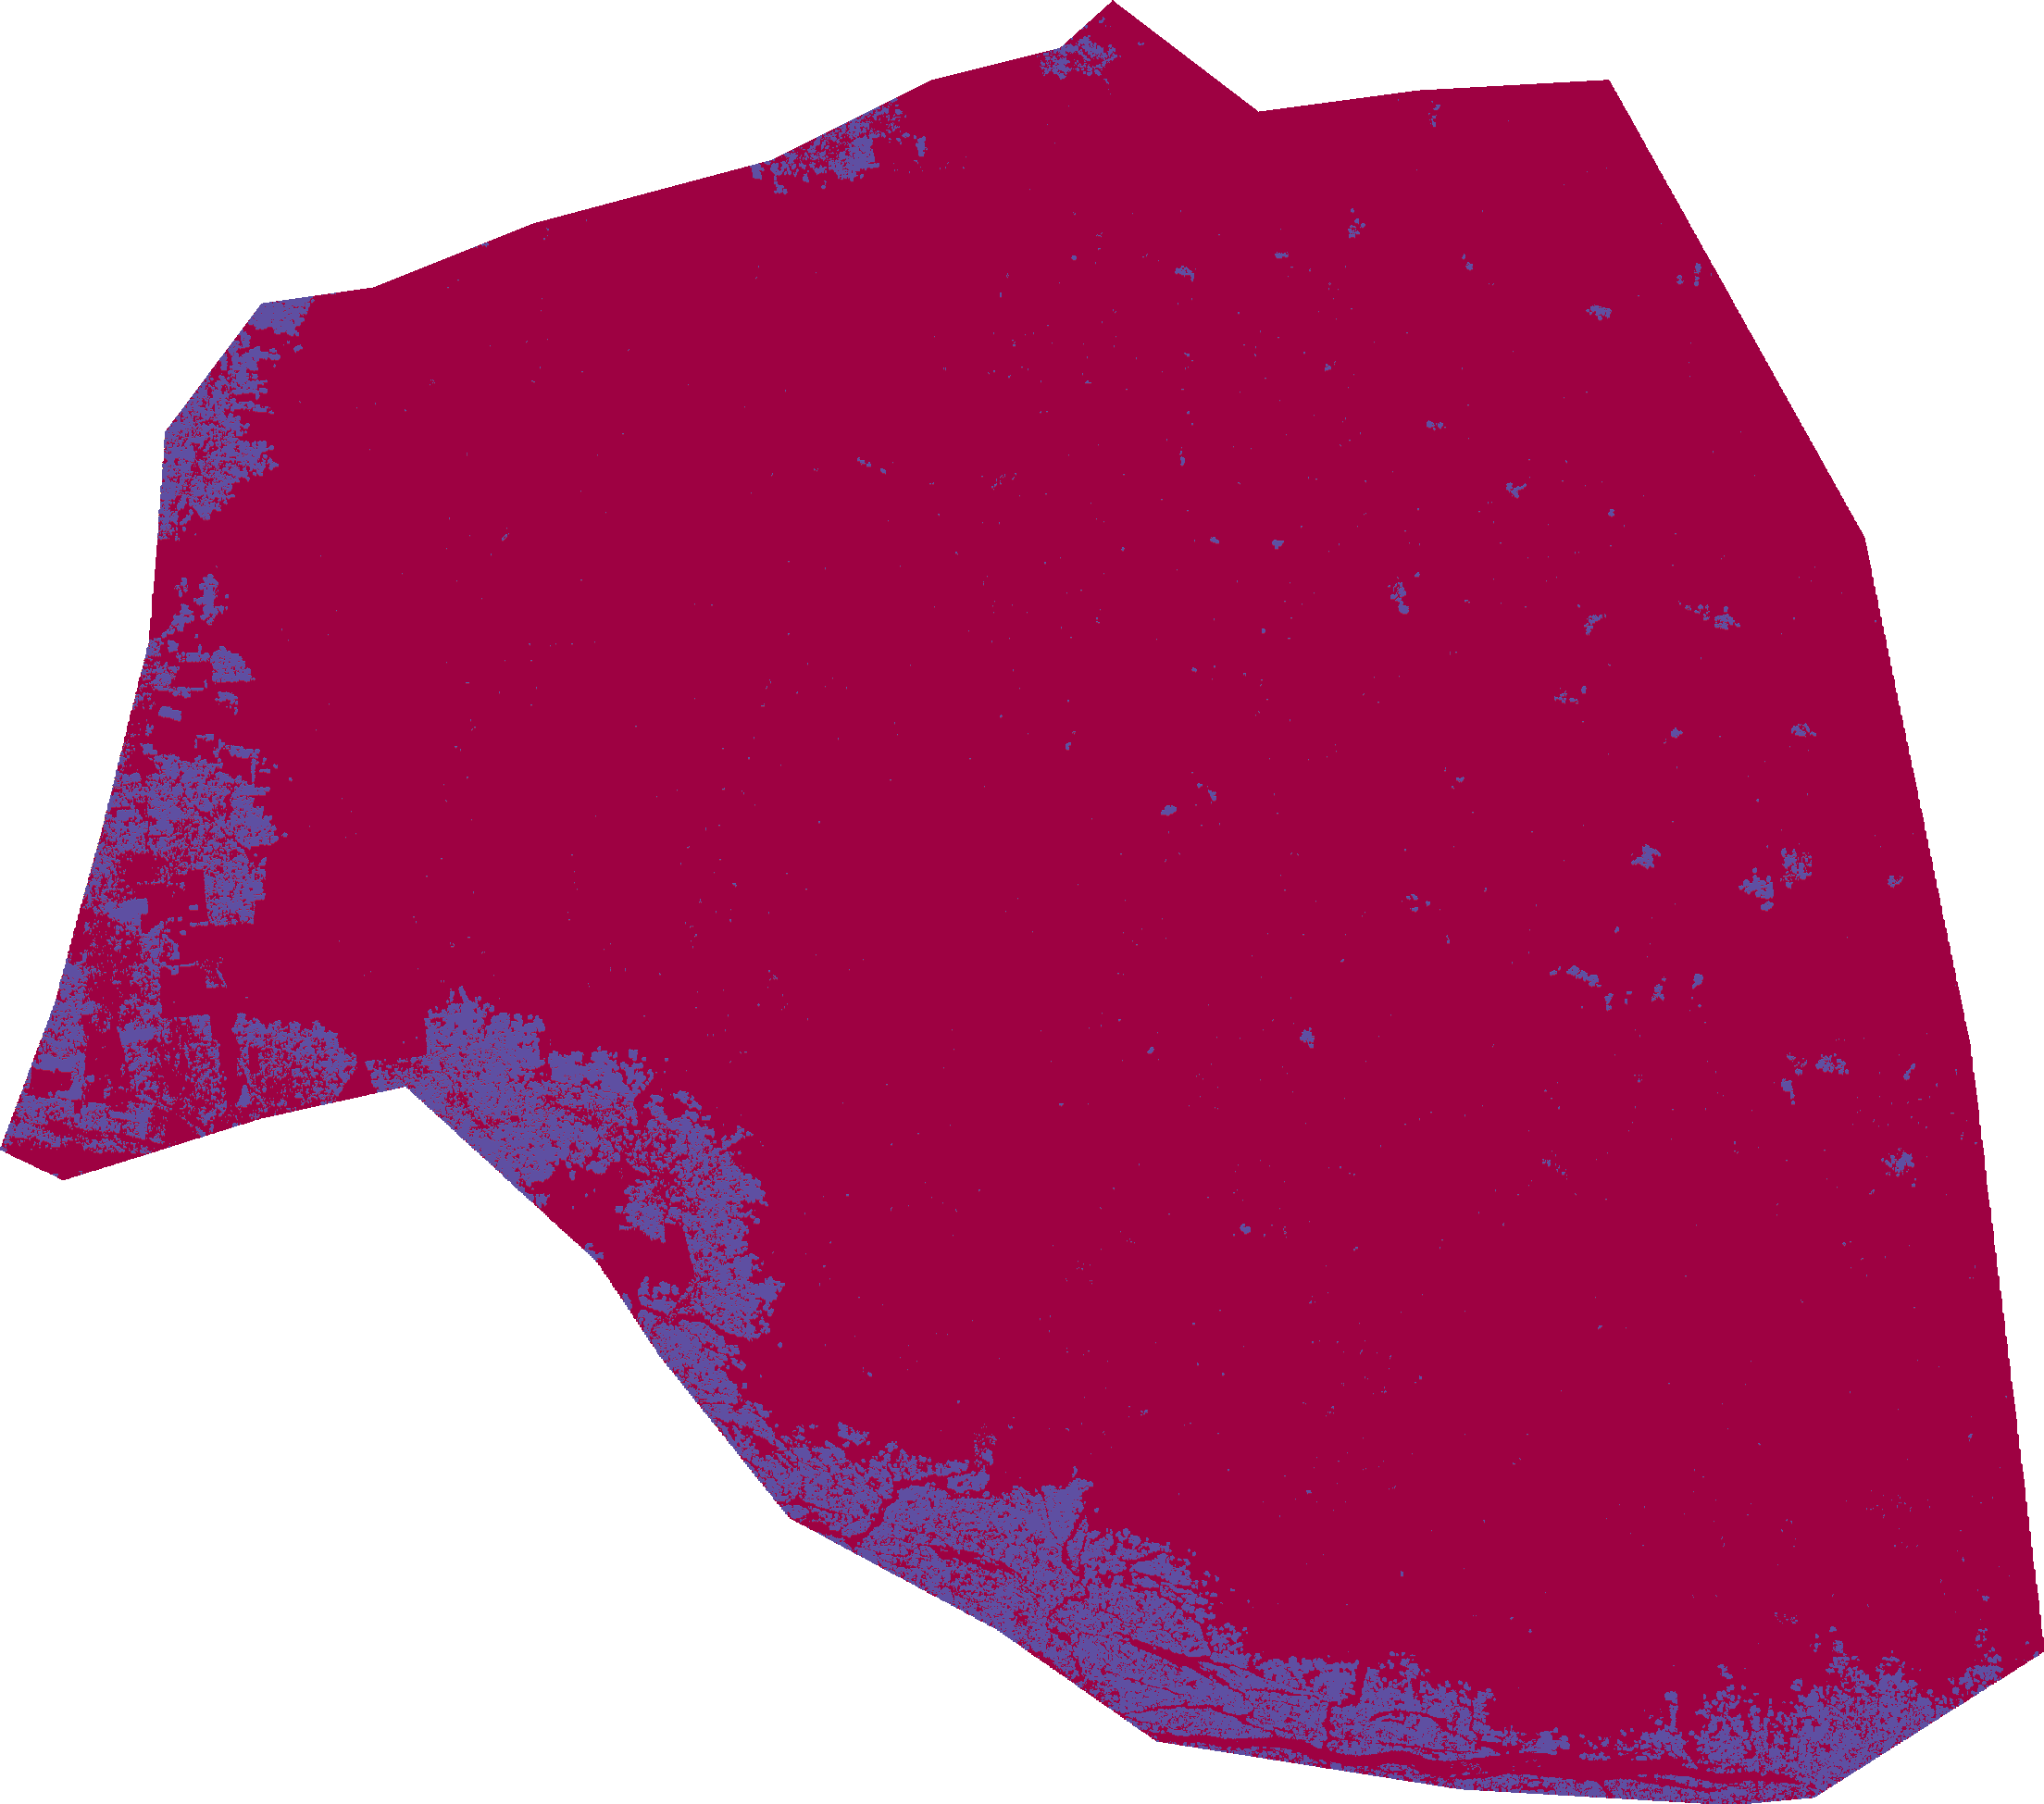

In [14]:
PA_map <- leaflet() %>%  addTiles() %>%  
  addRasterImage(PA_1_masked, opacity = 0.8) %>%
  addRasterImage(PA_2_masked, opacity = 0.8)

PA_map